# First 15 minutes Long-Short - Detection(Predict, Classification)

### Import Library

In [108]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
#
from sklearn.cluster import KMeans
#
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [109]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [110]:
data = dataset.copy()

In [111]:
data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')].copy()

In [112]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-09-30 14:15:00,1353.1,1353.9,1351.5,1353.1,6265
2024-09-30 14:20:00,1353.0,1354.7,1352.6,1354.6,4426
2024-09-30 14:25:00,1354.6,1356.3,1354.1,1355.9,7920


In [113]:
_15m_data = data.copy().resample("15min").agg({
        'Open': 'first',
        'Close': 'last',
        'Low': 'min',
        'High': 'max',
        'Volume': 'sum'
    })

In [114]:
_15m_data.dropna(inplace=True)

In [115]:
_15m_data

,Open,Close,Low,High,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,899.5,898.7,900.2,4909
2020-11-02 09:15:00,899.4,898.5,896.5,899.5,6268
2020-11-02 09:30:00,898.5,898.8,898.3,899.8,4993
2020-11-02 09:45:00,898.8,901.3,897.7,901.4,6834
2020-11-02 10:00:00,901.3,899.7,898.9,901.3,4926
...,...,...,...,...,...
2024-09-30 13:45:00,1354.0,1353.0,1352.9,1355.2,8932
2024-09-30 14:00:00,1353.2,1353.1,1352.3,1355.0,8888
2024-09-30 14:15:00,1353.1,1355.9,1351.5,1356.3,18611


In [116]:
ato_data = _15m_data[(_15m_data.index.hour == 9) & (_15m_data.index.minute == 0)]

In [117]:
ato_data['return'] = ato_data['Close'] - ato_data['Open']
# ato_data['return'] = ato_data.apply(lambda r: r['High'] - r['Open'] if r['High'] - r['Open'] > abs(r['Low'] - r['Open']) else r['Low'] - r['Open'], axis=1)

In [118]:
# quantile signal data
deq_low = ato_data["return"].quantile(0.01)
deq_high  = ato_data["return"].quantile(0.99)
ato_data = ato_data[(ato_data["return"] < deq_high) & (ato_data["return"] > deq_low)]

In [119]:
ato_data

,Open,Close,Low,High,Volume,return
Date,,,,,,
2020-11-02 09:00:00,900.1,899.5,898.7,900.2,4909,-0.6
2020-11-03 09:00:00,909.3,908.6,908.2,909.4,3954,-0.7
2020-11-04 09:00:00,909.0,908.8,907.5,909.9,4312,-0.2
2020-11-05 09:00:00,913.7,913.3,913.2,914.7,4721,-0.4
2020-11-06 09:00:00,911.2,911.5,911.0,912.0,3698,0.3
...,...,...,...,...,...,...
2024-09-24 09:00:00,1326.0,1325.6,1324.9,1326.0,6191,-0.4
2024-09-25 09:00:00,1337.3,1339.2,1336.9,1339.2,11583,1.9
2024-09-26 09:00:00,1345.9,1346.9,1345.2,1347.5,8981,1.0


In [120]:
ato_data['return'].max()

9.299999999999955

In [121]:
ato_data['return'].min()

-8.799999999999955

In [122]:
new_15m_data = pd.merge(_15m_data, ato_data[["return"]], left_index=True, right_index=True, how="left")

In [123]:
new_15m_data

,Open,Close,Low,High,Volume,return
Date,,,,,,
2020-11-02 09:00:00,900.1,899.5,898.7,900.2,4909,-0.6
2020-11-02 09:15:00,899.4,898.5,896.5,899.5,6268,NaN
2020-11-02 09:30:00,898.5,898.8,898.3,899.8,4993,NaN
2020-11-02 09:45:00,898.8,901.3,897.7,901.4,6834,NaN
2020-11-02 10:00:00,901.3,899.7,898.9,901.3,4926,NaN
...,...,...,...,...,...,...
2024-09-30 13:45:00,1354.0,1353.0,1352.9,1355.2,8932,NaN
2024-09-30 14:00:00,1353.2,1353.1,1352.3,1355.0,8888,NaN
2024-09-30 14:15:00,1353.1,1355.9,1351.5,1356.3,18611,NaN


## 1. Clustering by last 4 candlesticks

In [124]:
df1 = new_15m_data.copy()
df1['Close_s1'] = df1['Close'].shift(1)
df1['Close_s2'] = df1['Close'].shift(2)
df1['Close_s3'] = df1['Close'].shift(3)
df1['Close_s4'] = df1['Close'].shift(4)
useful_data = df1[(df1.index.hour == 9) & (df1.index.minute == 0)]
useful_data.dropna(inplace=True)

In [125]:
feature_cols = ["Close_s1", "Close_s2", "Close_s3", "Close_s4"]
cluster = KMeans(n_clusters=20, n_init=2).fit(useful_data[feature_cols])
useful_data = useful_data.assign(cluster=cluster.labels_)

<Axes: xlabel='cluster'>

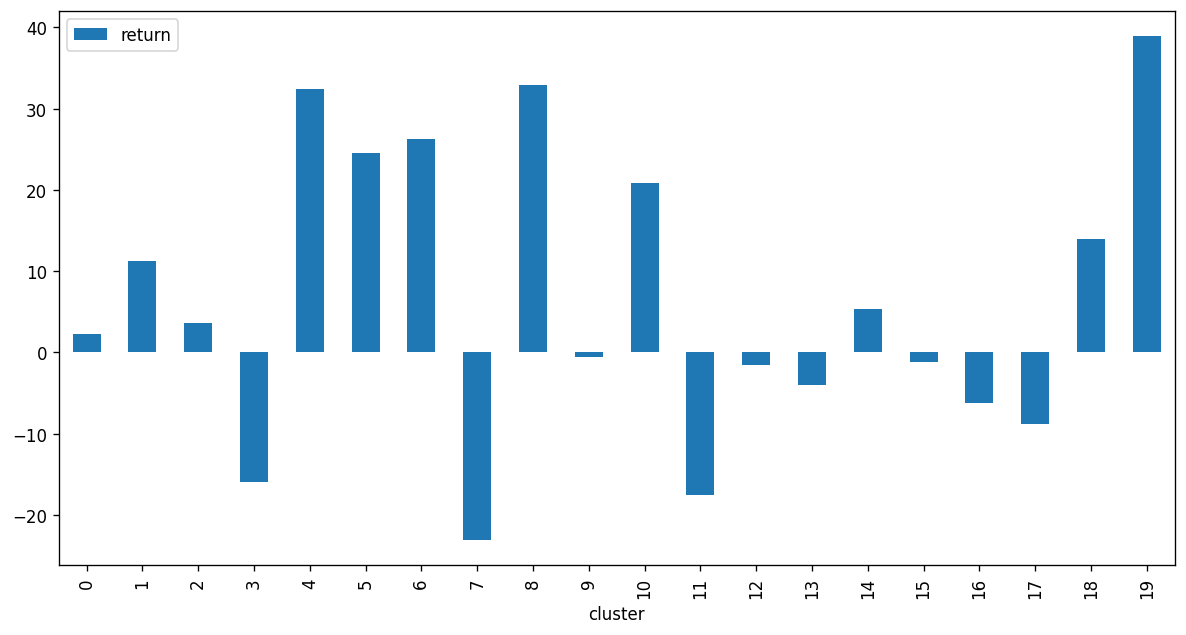

In [126]:
group_by_cluster = useful_data.groupby(['cluster'])[['return']].sum()
group_by_cluster.plot.bar()

<Axes: xlabel='cluster'>

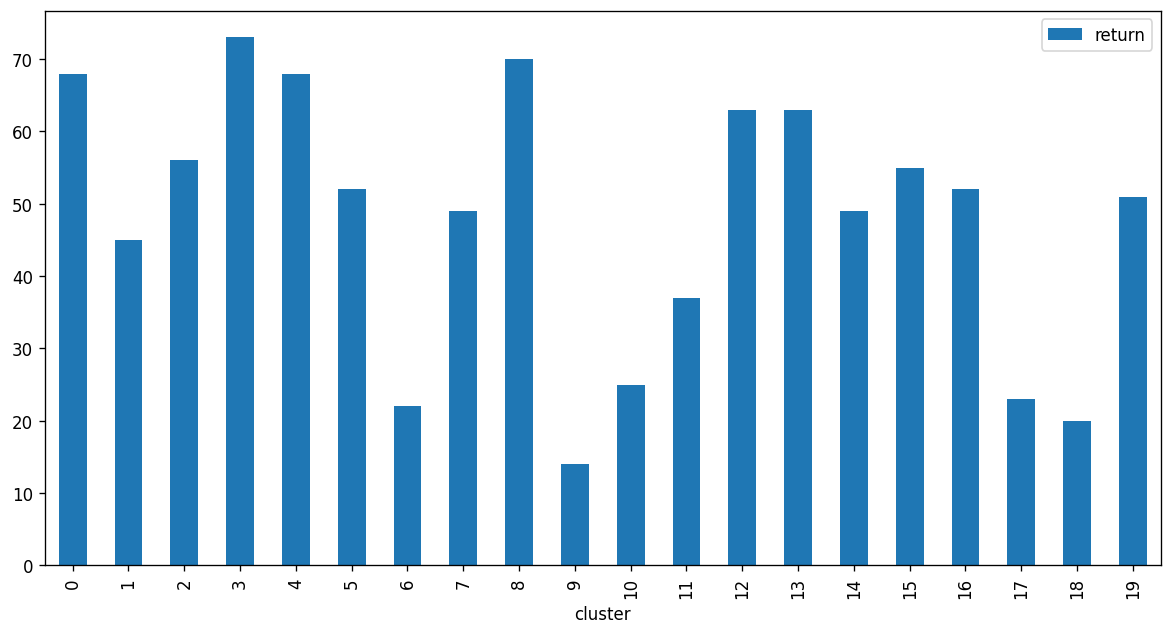

In [127]:
group_by_clusterc = useful_data.groupby(['cluster'])[['return']].count()
group_by_clusterc.plot.bar()